In [462]:
# !pip install html2image

# Start Here

In [463]:
import json
import os
import random
import re
import textwrap

from html2image import Html2Image
from nltk.corpus import stopwords, wordnet
from nltk.metrics.distance import edit_distance
import pytrends
import nltk
from tqdm import tqdm

from sumy.nlp.stemmers import Stemmer
from sumy.nlp.tokenizers import Tokenizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer

In [464]:
spell_check_flag = False

In [465]:
stopwords = stopwords.words('english')

In [466]:
import textstat

def determine_grade_level(summary):
    """
    determine_grade_level - generates a grade level for the given summary using the Flesch-Kincaid Grade Level formula

    The Flesch-Kincaid Grade Level formula is a readability test designed to indicate how difficult a passage in English is to understand. The score is based on the average number of syllables per 100 words and the average number of words per sentence. The higher the score, the more difficult the text is to understand.

    :param summary: _description_
    :type summary: _type_
    :return: _description_
    :rtype: float
    """
    grade_level = textstat.flesch_kincaid_grade(summary)
    return grade_level

In [467]:
with open('ppn_deck.json', 'r') as read_file:
    card_deck = json.load(read_file)



In [468]:
# for each of the cards, generate a grade_level score and add it to the json file under the key "grade_level"
for card in tqdm(card_deck):
    summary = card['summary']
    grade_level = determine_grade_level(summary)
    card['grade_level'] = grade_level

100%|██████████| 7384/7384 [00:02<00:00, 3068.08it/s]


In [469]:
# add length of summary to the df column "summary_length"
import pandas as pd
df = pd.DataFrame(card_deck)
df['summary_length'] = df['summary'].apply(lambda x: len(x))


In [470]:
# convert the card_deck to a json file, to a df using pandas and then to a csv file
with open("ppn_deck_cleaned.json", "w") as write_file:
    json.dump(card_deck, write_file, indent=4)

# read card_deck from ppn_deck.json file
# with open("ppn_deck.json", "r") as read_file:
# card_deck = json.load(read_file)
with open("ppn_deck_cleaned.json", "r") as read_file:
    card_deck = json.load(read_file)
    
# convert card_deck to a pandas dataframe
df.head()

,title,summary,related,summary_short,summary_clean,point_value,grade_level,points_for_card,acronym,years_in_summary,years_in_title,points_by_year_mentioned,cleaned,summary_length
0,Rosetta Cammeniti,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",321,- Rose - is a sectional character from the...,None,321,9.8,1.0,False,2,0,2,True,434
1,Spy Muppets: License to Croak,"Spy Muppets: License to Croak, Spy Muppets: Li...",164,"is an action video game, part of The Suppers f...",None,164,10.6,5.0,False,1,0,2,True,415
2,Fame in the 20th Century,"Fame in the 20th Century, Fame in the 20th Cen...",591,is a 1993 BBC documentary television series an...,None,591,10.6,5.0,False,4,0,2,True,1143
3,Becca Hayton,"Becca Hayton, Becca Dean also Hayton is a fict...",271,- Mean also - is a sectional character fro...,None,271,10.1,5.0,False,2,0,2,True,209
4,Brigitte Bardot,"Brigitte Bardot, Brigitte Anne-Marie Bardot li...",773,- Anne-Marie - listen bring-EET bar-DOH; F...,None,773,9.8,3.0,False,13,0,2,True,2139


In [471]:
# points for the card should be calculated by the following formula:
# - the higher the grade level of the card, the higher the points.
# - the more words in the summary, the lower the points.
# - cards with longer titles should have higher points.
# - cards with Acronyms should have higher points.

# create a new column in the dataframe called "points_for_card"
df['points_for_card'] = 0
df['acronym'] = False # this will need to be updated later to determine if the card has an acronym or not

def determine_points(card):
    # determine the points for the card based on the following formula:
    # - the higher the grade level of the card, the higher the points.
    # - the more words in the summary, the lower the points.
    # - cards with longer titles should have higher points.
    # - cards with Acronyms should have higher points.
    grade_level = card['grade_level']
    summary = card['summary']
    title = card['title']
    acronym = card['acronym']
    related_pages = card['related']
    points = 0
    # - the higher the grade level of the card, the higher the points.
    # all _score variables will be between 0 and 100
    grade_score = grade_level
    # - the more words in the summary, the lower the points.
    summary_score = len(summary.split())
    # - cards with longer titles should have higher points.
    title_score = len(title.split())
    # - cards with Acronyms should have higher points.
    acronym_score = 0
    if acronym:
        acronym_score = 1
    # - cards with related pages should have higher points.
    try:
        related_pages_score = int(related_pages)
    except ValueError:
        related_pages_score = 0
    except Exception:
        related_pages_score = 0
    #print(grade_score)
    #print(summary_score)
    #print(title_score)
    #print(acronym_score)

    #print(related_pages_score)

    # calculate the points
    points = grade_score + summary_score + title_score + acronym_score + related_pages_score
    #print(points)

    return int(points)

# apply the determine_points function to each of the cards in the dataframe
df['points_for_card'] = df.apply(determine_points, axis=1)
# now scale the points_for_card column to be between 1 and 10, and round to the nearest integer
df['points_for_card'] = df['points_for_card'].apply(lambda x: round((x - df['points_for_card'].min()) / (df['points_for_card'].max() - df['points_for_card'].min()) * 10))
# replace any points_for_card values that are 0 with 1
df['points_for_card'] = df['points_for_card'].apply(lambda x: 1 if x == 0 else x)
# no card with a grade level above 10 should have a points_for_card value less than 5
df['points_for_card'] = df.apply(lambda x: 5 if x['grade_level'] > 10 and x['points_for_card'] < 5 else x['points_for_card'], axis=1)
df.head()

,title,summary,related,summary_short,summary_clean,point_value,grade_level,points_for_card,acronym,years_in_summary,years_in_title,points_by_year_mentioned,cleaned,summary_length
0,Rosetta Cammeniti,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",321,- Rose - is a sectional character from the...,None,321,9.8,1,False,2,0,2,True,434
1,Spy Muppets: License to Croak,"Spy Muppets: License to Croak, Spy Muppets: Li...",164,"is an action video game, part of The Suppers f...",None,164,10.6,5,False,1,0,2,True,415
2,Fame in the 20th Century,"Fame in the 20th Century, Fame in the 20th Cen...",591,is a 1993 BBC documentary television series an...,None,591,10.6,5,False,4,0,2,True,1143
3,Becca Hayton,"Becca Hayton, Becca Dean also Hayton is a fict...",271,- Mean also - is a sectional character fro...,None,271,10.1,5,False,2,0,2,True,209
4,Brigitte Bardot,"Brigitte Bardot, Brigitte Anne-Marie Bardot li...",773,- Anne-Marie - listen bring-EET bar-DOH; F...,None,773,9.8,3,False,13,0,2,True,2139


In [472]:
# look for years in the summary and title. Older cards should have higher points, so we will add 1 point for each year found in the summary and title (this will be scaled later)
import re
df['years_in_summary'] = df['summary'].apply(lambda x: len(re.findall(r'\d{4}', x)))
df['years_in_title'] = df['title'].apply(lambda x: len(re.findall(r'\d{4}', x)))
def points_by_year_mentioned(this_card,years_in_deck):
    # assign higher points for years that are older (i.e 1980 has higher points than 2010 etc.) This is on a scale so highest points are for the oldest years.
    # this card may mention multiple years, so we will add the points for each year mentioned by where it falls in the scale of years in the deck.
    # for example, if the card mentions 1980 and 2010, and the deck has cards from 1980 to 2020, then the points for the card will be 1 + 10 = 11
    points = 0
    years_in_summary = this_card['years_in_summary']
    years_in_title = this_card['years_in_title']
    years_mentioned = years_in_summary + years_in_title
    if years_mentioned > 0:
        # get the year mentioned in the summary and title
        years = re.findall(r'\d{4}', this_card['summary']) + re.findall(r'\d{4}', this_card['title'])
        # convert the years to integers
        years = [int(x) for x in years]
        # get the min and max year in the deck
        min_year = min(years_in_deck)
        max_year = max(years_in_deck)
        # get the range of years in the deck
        range_of_years = max_year - min_year
        # get the range of points
        range_of_points = 10
        # get the points for each year mentioned
        for year in years:
            points_for_year = round((year - min_year) / range_of_years * range_of_points)
            points += points_for_year
    return points

# get the years in the deck by looking at all summaries and titles for years and getting the unique years mentioned. years are between 1950 and 2022.
years_in_deck = []
for index, row in df.iterrows():
    years_in_deck += re.findall(r'\d{4}', row['summary'])
    years_in_deck += re.findall(r'\d{4}', row['title'])
# convert the years to integers
years_in_deck = [int(x) for x in years_in_deck]
# get the unique years
years_in_deck = list(set([int(x) for x in years_in_deck]))
# sort the years
years_in_deck.sort()
# filter out years that are not between 1950 and 2022
years_in_deck = [x for x in years_in_deck if x >= 1950 and x <= 2022]
# print(years_in_deck)
# apply the points_by_year_mentioned function to each of the cards in the dataframe
df['points_by_year_mentioned'] = df.apply(lambda x: points_by_year_mentioned(x,years_in_deck), axis=1)

# now scale the points_by_year_mentioned column to be between 1 and 10, and round to the nearest integer
df['points_by_year_mentioned'] = df['points_by_year_mentioned'].apply(lambda x: round((x - df['points_by_year_mentioned'].min()) / (df['points_by_year_mentioned'].max() - df['points_by_year_mentioned'].min()) * 10))
# replace any points_by_year_mentioned values that are 0 with 1
df['points_by_year_mentioned'] = df['points_by_year_mentioned'].apply(lambda x: 1 if x == 0 else x)

# now add the points_by_year_mentioned to the points_for_card
df['points_for_card'] = df['points_for_card'] + df['points_by_year_mentioned']
# now scale the points_for_card column to be between 1 and 10, and round to the nearest integer
df['points_for_card'] = df['points_for_card'].apply(lambda x: round((x - df['points_for_card'].min()) / (df['points_for_card'].max() - df['points_for_card'].min()) * 10))
# replace any points_for_card values that are 0 with 1
df['points_for_card'] = df['points_for_card'].apply(lambda x: 1 if x == 0 else x)
df.head()

,title,summary,related,summary_short,summary_clean,point_value,grade_level,points_for_card,acronym,years_in_summary,years_in_title,points_by_year_mentioned,cleaned,summary_length
0,Rosetta Cammeniti,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",321,- Rose - is a sectional character from the...,None,321,9.8,1,False,2,0,2,True,434
1,Spy Muppets: License to Croak,"Spy Muppets: License to Croak, Spy Muppets: Li...",164,"is an action video game, part of The Suppers f...",None,164,10.6,5,False,1,0,2,True,415
2,Fame in the 20th Century,"Fame in the 20th Century, Fame in the 20th Cen...",591,is a 1993 BBC documentary television series an...,None,591,10.6,5,False,4,0,2,True,1143
3,Becca Hayton,"Becca Hayton, Becca Dean also Hayton is a fict...",271,- Mean also - is a sectional character fro...,None,271,10.1,5,False,2,0,2,True,209
4,Brigitte Bardot,"Brigitte Bardot, Brigitte Anne-Marie Bardot li...",773,- Anne-Marie - listen bring-EET bar-DOH; F...,None,773,9.8,3,False,13,0,2,True,2139


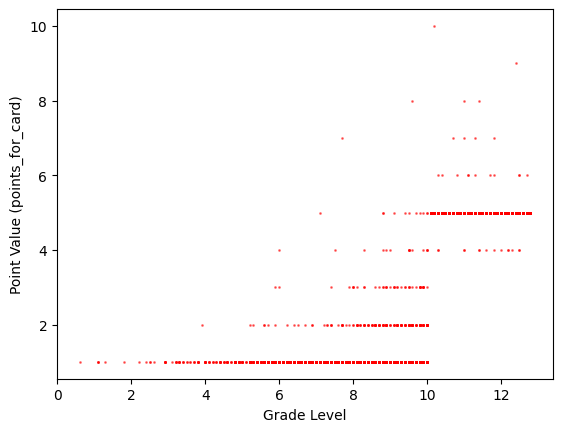

In [473]:
# remove cards that are beyond the 95th percentile using IQR method
# calculate the 95th percentile
grade_level_95th_percentile = df['grade_level'].quantile(0.95)
# remove cards that are beyond the 95th percentile
df = df[df['grade_level'] < grade_level_95th_percentile]
# remove any cards with negative point values or grade levels
df = df[df['point_value'] > 0]
df = df[df['grade_level'] > 0]
# show the distribution of grade levels

# plot grade levels vs point values
import matplotlib.pyplot as plt
plt.scatter(df['grade_level'], df['points_for_card'], color='red', alpha=0.5, s=1)
plt.xlabel('Grade Level')
plt.ylabel('Point Value (points_for_card)')
plt.show()

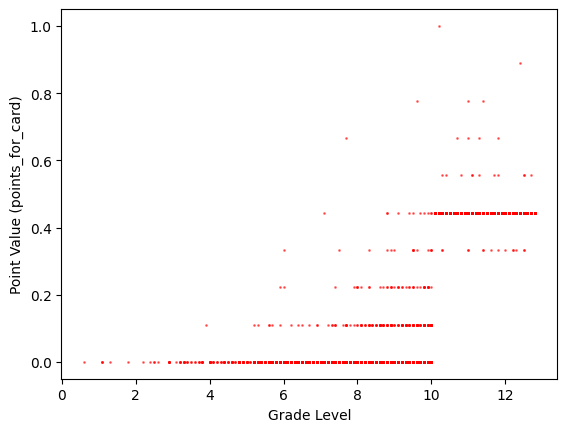

In [474]:
# use min-max normalization to normalize the point values
# calculate the min and max point values
min_point_value = df['points_for_card'].min()
max_point_value = df['points_for_card'].max()
# normalize the point values
df['points_for_card'] = (df['points_for_card'] - min_point_value) / (max_point_value - min_point_value)
# plot grade levels vs point values
import matplotlib.pyplot as plt
plt.scatter(df['grade_level'], df['points_for_card'], color='red', alpha=0.5, s=1)
plt.xlabel('Grade Level')
plt.ylabel('Point Value (points_for_card)')
plt.show()


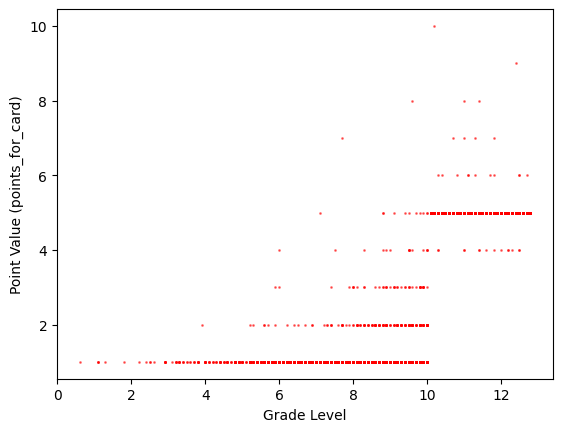

In [475]:
# now use minmaxscaler to normalize the point values between 0, and 10 by steps of 1 (i.e. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10) using rounding to the nearest integer. This will be used to generate the point values for the cards.
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(1, 10))
# fit the scaler to the point values
scaler.fit(df[['points_for_card']])
# transform the point values
df['points_for_card'] = scaler.transform(df[['points_for_card']])
# round the point values to the nearest integer
df['points_for_card'] = df['points_for_card'].round()
# plot grade levels vs point values
import matplotlib.pyplot as plt
plt.scatter(df['grade_level'], df['points_for_card'], color='red', alpha=0.5, s=1)
plt.xlabel('Grade Level')
plt.ylabel('Point Value (points_for_card)')
plt.show()

In [476]:
# save the dataframe to a json file in place of the ppn_deck.json file
df.to_json('ppn_deck.json', orient='records')


---

In [477]:
# now remove any cards with profanity in the title or summary
# !pip install sklearn --upgrade
# !pip install joblib --upgrade
# !pip install scipy --upgrade
# !pip install alt-profanity-check

from profanity_check import predict, predict_prob

# if the probability of profanity is greater than 0.7, then remove the card.

---

In [478]:
def clear_card_box(card_box_directory):
    for file in os.listdir(card_box_directory):
        os.remove(os.path.join(card_box_directory, file))

# clear the card box directory
clear_card_box('new_card_box')

In [479]:
from PIL import Image

def crop_image(input_file, output_file):
    # Open the input image
    img = Image.open(input_file)

    # Crop the image to maintain a 14px buffer on the left, top, bottom, and right
    # of a rectangle that is 1182px wide and 1779px tall, starting from the upper left
    left = 14 # buffer
    cropped_img = img.crop((left, 14, 1182+left, 1779+left))

    # Save the cropped image to the specified output file
    cropped_img.save(output_file)


In [480]:
with open('card_html.txt', 'r') as f:
    html_template = f.read()

In [481]:
# using contextual spell checking
# verify that python -m spacy download en_core_web_sm has been run
#!python -m spacy download en_core_web_sm

#!pip install textblob
from textblob import TextBlob
#!pip install autocorrect 
from autocorrect import Speller # for spell checking

In [482]:
# import spacy


# import contextualSpellCheck
# nlp = spacy.load('en_core_web_sm')
# contextualSpellCheck.add_to_pipe(nlp)

In [483]:
import re
import textblob

In [484]:

def summarize_text(text, num_sentences):
    """
    Summarize the given text using the LSA or LexRank summarization algorithms and return the summary as a string
    """
    # create a PlaintextParser object to parse the text
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    # choose a summarization algorithm
    # algorithm = LsaSummarizer()
    algorithm = LexRankSummarizer()

    # summarize the text and return the summary as a string
    summary = algorithm(parser.document, num_sentences)
    summary_text = "\n".join([str(sentence) for sentence in summary])

    return summary_text

def generate_card(title: str, description: str, points: str, html_template: str,  name: str, links_on_wikipedia: str, category = 'Wild Card'):
    filename = '{}.png'.format(title.replace(' ', '_'))
    if os.path.exists('./card_box/{}'.format(filename)) and 'Test_Card' not in filename:
        print(f'Card {title} already exists, skipping...')
        return # skip this card if it already exists
    # Set the dimensions in centimeters
    
    #todo - make the color of the card dependent on the number of links on wikipedia
    # the shade of green represents the number of links on wikipedia
    # the darker the green, the more links on wikipedia
    # the lighter the green, the fewer links on wikipedia
    # the color is a hex code that is a combination of the red, green, and blue values
    # the red value is 0
    # the green value is 255 - 255 * (links_on_wikipedia / 100)
    # the blue value is 0
    #colorcode = int(255 - 255 * (links_on_wikipedia / 100))
    #card_color = '#{:02x}{:02x}{:02x}'.format(0, colorcode, 0)
    # color_code = 'green'
    width_cm = 5.5
    height_cm = 8.5
    card_color = 'green'
    # Convert the dimensions to pixels
    # 1 cm is equal to 96 pixels
    width_pixels = int(width_cm * 96)
    height_pixels = int(height_cm * 96)
    points = int(points) # removes the decimal point
    points = str(points) # now it's a string
    links_on_wikipedia = str(links_on_wikipedia)
    # replace the placeholders with the actual values
    html = html_template

    # replace the category in the description with 'THIS'

    # if the title has a "(" something ")" in it then that something is the category of the card, remove it from the title, and assign the category to the category variable.
    if '(' in title and ')' in title:
        category = title[title.index('(')+1:title.index(')')]
        title = title.replace('({})'.format(category), '')
        category = category.strip()
    # if the title has a "[" something "]" in it then that something is the category of the card, remove it from the title, and assign the category to the category variable.
    elif '[' in title and ']' in title:
        category = title[title.index('[')+1:title.index(']')]
        title = title.replace('[{}]'.format(category), '')
        category = category.strip()
    # if the title has a "{" something "}" in it then that something is the category of the card, remove it from the title, and assign the category to the category variable.
    else:
        if category == 'other':
            category = 'Wild Card'

    title_bigrams = list(nltk.bigrams(title.split(' '))) # get the bigrams of the title (e.g. ['this', 'is'] and ['is', 'a'] for the title 'this is a title')
    # get the bigrams with no stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    title_bigrams = [bigram for bigram in title_bigrams if bigram[0] not in stopwords and bigram[1] not in stopwords]

    # for each bigram in the title, if the bigram is in the description, replace it with ' this {} '.format(category)
    for bigram in title_bigrams:
        bigram = ' '.join(bigram)
        if bigram in description:
            description = description.replace(bigram, ' This {} '.format(category))
    # also, in the description, remove the ' - ' phrase and replace it with 'SUBJECT'
    description = description.replace(' - ', ' ')
    # keep removing double spaces until there are no more double spaces in the description.
    def format_description(description):
        while '  ' in description:
            description = description.replace('  ', ' ')

    description = clean_string(description) # clean the description

    assert(len(description) > 0, "There is no Description") # make sure the description is not empty
    html = html.replace('CARD_TITLE', title)
    html = html.replace('CARD_DESCRIPTION', description)
    html = html.replace('CARD_CATEGORY', category)
    html = html.replace('CARD_POINTS', str(points))
    html = html.replace('CARD_NAME',str(title))
    html = html.replace('CARD_COLOR',str(card_color))
    # replace the width_pixels and height_pixels with the actual values
    html = html.replace('WIDTH_PIXELS',str(width_pixels))
    html = html.replace('HEIGHT_PIXELS',str(height_pixels))
    html = html.replace('WIKILINKS',str(links_on_wikipedia))
    # Create an Html2Image object
    hti = Html2Image()

    # Generate a screenshot of the HTML content and save it to a file
    output_path = './card_box/'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    savepath = os.path.join(output_path, filename)
    hti.output_path = output_path


    # Generate the image
    # make the filename the title of the card, with underscores instead of spaces, and no punctuation or special characters.
    filename = '{}.png'.format(title.replace(' ', '_')) # make the filename the title of the card, with underscores instead of spaces, and no punctuation or special characters.
    filename = filename.lower()
    hti.screenshot(html_str=html, save_as=filename)
    # Crop the image (at the filename (path))
    print(f'Generated card {title} at {savepath}!')
    
    savepath_out = './new_card_box/{}.png'.format(title.replace(' ', '_').replace('.', '').replace(',', '').replace(';', '').replace(':', '').replace('?', '').replace('!', '').replace('-', '').replace('"', '').replace("'", '').replace('(', '').replace(')', '')).lower() # make the filename the title of the card, with underscores instead of spaces, and no punctuation or special characters.
    crop_image(savepath, savepath_out)
    # delete the original image
    os.remove(savepath)
    print(f'Cropped card {title} at {savepath}!')

def run_spell_check_on_cards(nlp):
    #note: this function takes a long time to run, very top heavy
    # open the json file
    with open('ppn_deck.json', 'r') as f:
        card_deck = json.load(f)
    
    # loop through the cards
    for card in tqdm(card_deck):
        # get the summary
        summary = card['summary_short']
        if isinstance(summary, list):
            summary = summary[1]

        # using contextualSpellCheck to correct the spelling
        doc = nlp(summary)
        if doc._.performed_spellCheck: # if the spell check was performed
            # reassign summary to the corrected version
            summary = doc._.outcome_spellCheck
            card['summary_short'] = summary # update the card
        else:
            print('Spell check was not performed')

import numpy as np
def generate_physical_cards(options):
    print(f'Generating physical cards...')
    print(f'With the following options: {options}')
    print('--'*20)
    # get the options from the options dictionary
    cards_to_generate = options['cards_to_generate'] # the number of cards to generate
    profanity = options['profanity'] # if True, profanity will be allowed in the cards
    grade_level = options['grade_level'] # the maximum grade level of the cards
    keywords = options['keywords'] # if card summary (full) contains any of these keywords, it will be included in the deck of cards as a card with the category matching the keyword. If the keyword is not in the list of categories, it will be added to the list of categories.

    # open the json file
    with open('ppn_deck.json', 'r') as f:
        card_deck = json.load(f)

    # Iterate through each card and generate a card image for it
    # randomly sample cards_to_generate cards from the card deck
    card_deck = random.sample(card_deck, cards_to_generate)
    # loop through the cards
    for card in tqdm(card_deck):
        if gandalf_card_finder(card, keywords, grade_level, profanity=False):
            pass # if the card passes the gandalf card finder, then it is a card that we want to generate, so we can continue to the next step
        else:
            continue # if the card does not pass the gandalf card finder, then it is not a card that we want to generate, so we can skip to the next card. 
        # Prepare the summary and points variables
        summary = card['summary'] #note: this is where I changed summary_short to summary
        summary = str(summary)
        # print('Summary Shortening')
        if isinstance(summary, str):
            # if the summarized text fills more than 3/4 the height of the card, summarize it again with one fewer sentence. This is to prevent the text from overflowing the card.
            # max at font size 20 is 25 lines
            sentence_count = 5 # the number of sentences in the summary (initially)
            iterator = 1
            summary = summarize_text(summary, 3)
            if isinstance(summary, list):
                summary = ' '.join(summary)
        else:
            raise ValueError('Summary is not a string!')
        card['final_summary'] = summary
        # the category is the keyword that is in the summary most (mode) or the first keyword that is in the summary (first)
        # numpy has no mode function, so we will use the first keyword that is in the summary
        try:
            card['category'] = [keyword for keyword in keywords if keyword in summary][0] # the first keyword that is in the summary
        except IndexError:
            card['category'] = 'other'
        
        category = card['category']
        # card['category'] = any(keyword in summary for keyword in keywords)
        points = card['points_for_card']
        # Generate the card
        generate_card(str(card['title']),
                      summary, points=points,
                      html_template=html_template,
                      name=str(card['title']),
                      links_on_wikipedia=card['related'],
                      category= category)

def gandalf_card_finder(card, keywords, grade_level, profanity):
    # gandalf scans the card and determines if it is a good card or not for the game. For example, if the card contains any profanity and the profanity is set to false AND it contains a keyword, it is still not a good card because it failed one of the two requirements, with profanity being the most important.
    # if the card is good, it returns True, otherwise it returns False
    
    print(f'Gandalf is automatically adding keywords for the 2018-2022 years to the deck.')
    
    for year in range(2018, 2023):
        keywords.append(str(year))

    assert('summary' in card.keys(), 'Card does not have a summary!')
    full_summary = card['summary']
    if isinstance(full_summary, list):
        full_summary = full_summary[1]
    # check if the card contains any of the keywords using regex and word boundaries (r'\b')
    found_keyword = False # initialize the found_keyword variable
    for keyword in keywords:
        if re.search(r'\b' + keyword + r'\b', full_summary, re.IGNORECASE):
            # if the keyword is found, return True
            found_keyword = True
            break
        else:
            #print(f'Keyword {keyword} not found in card {card["title"]}.')
            found_keyword = False
    # profanity check here
    profanity = False #note: this is not implemented yet
    
    #todo - implement profanity check
    #todo - implement grade level check
    grade_level_check = True #note: this is not implemented yet
    # check the grade level of the card
    if float(card['grade_level']) > float(grade_level):
        grade_level_check = False # if the grade level is too high, the card is not a good card
    # if the card is good, return True, otherwise return False
    if (found_keyword and grade_level_check) or grade_level_check:
        return True
    else:
        return False

def clean_string(string):
    # Remove non-alphanumeric characters at the beginning of sentences
    string = re.sub(r'(?<=[.!?])\s*[^a-zA-Z\d]', '', string)
    
    # Use TextBlob to correct syntax errors
    corrected_string = textblob.TextBlob(string).correct()
    
    # convert to string from TextBlob object
    corrected_string = str(corrected_string)
    description = corrected_string
    description = re.sub(r'\.(?=[^ ])', '. ', description)
    description = re.sub(r',(?=[^ ])', ', ', description)
    description = re.sub(r';(?=[^ ])', '; ', description)
    description = re.sub(r':(?=[^ ])', ': ', description)
    description = re.sub(r'\?(?=[^ ])', '? ', description)
    description = re.sub(r'!(?=[^ ])', '! ', description)
    description = re.sub(r'-(?=[^ ])', '- ', description)
    description = re.sub(r'"(?=[^ ])', '" ', description)
    description = re.sub(r"'(?=[^ ])", "' ", description)
    description = re.sub(r'\((?=[^ ])', '( ', description)
    description = re.sub(r'\)(?=[^ ])', ') ', description)
    corrected_string = description
    # Remove non-ASCII characters
    cleaned_string = re.sub(r'[^\x00-\x7F]+', '', corrected_string)

    # remove \n characters from the string
    cleaned_string = cleaned_string.replace('\n', ' ')

    # capitalize the first letter of each sentence in the description
    cleaned_string = cleaned_string.capitalize() # capitalize the first letter of the description
    # capitalize the first letter of each sentence in the description
    cleaned_string = re.sub(r'[\.\?\!]\s(?=[a-z])', '. ', cleaned_string) # capitalize the first letter of each sentence, except for the first sentence, which is already capitalized, and except for sentences that start with a number, which are not capitalized in the original text
    # replace the placeholders with the actual values
    assert(len(cleaned_string) > 0, 'Cleaned string is empty!')
    return cleaned_string

def run_cleaner_on_cards():
    # open the json file
    with open('ppn_deck.json', 'r') as f:
        card_deck = json.load(f)

    # loop through the cards
    for card in tqdm(card_deck):
        # get the summary
        if 'cleaned' in card.keys():
            continue
        summary = card['summary_short']
        if isinstance(summary, list):
            summary = summary[1]
        if isinstance(summary, list):
            summary = ' '.join(summary)
        # convert summary to string in case it's a list
        summary = str(summary)
        # clean the summary
        summary = clean_string(summary)
        # update the card
        card['summary_short'] = summary
        # add a new key to the card called 'cleaned' and set it to True
        card['cleaned'] = True
        # every 10 cards, save the json file
        if card_deck.index(card) % 10 == 0:
            #print(f'Saving at card {card_deck.index(card)}')
            with open('ppn_deck.json', 'w') as f:
                json.dump(card_deck, f)
        #print(f'Cleaned card {card["title"]} at index {card_deck.index(card)}! Summary: {summary}')
    # save the updated json file
    with open('ppn_deck.json', 'w') as f:
        json.dump(card_deck, f)

<>:84: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:209: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:271: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:84: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:209: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:271: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_96892/564036921.py:84: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(description) > 0, "There is no Description") # make sure the description is not empty
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_96892/564036921.py:209: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert('summary' in card.keys(), 'Card does not have a summary!')
/var/folders/34/d1tlq3k91hb0lj6x90xpzb4r0000gn/T/ipykernel_96892/56403

In [485]:
print("Initialized, ready to spell check!")
# run_spell_check_on_cards(nlp) # run the spell check
if spell_check_flag:
    run_cleaner_on_cards()
print("Spell check complete, ready to generate cards!")


Initialized, ready to spell check!
Spell check complete, ready to generate cards!


In [486]:
# generate a test card
generate_card('Test Card', 'from Armentires is an English song that was particularly popular during World War I. It is also known by its ersatz French hook line, Inky Pinky Parlez Vous, or the American variant Hinky Dinky Parlez-vous variant: Parlay voo. Inky Pinky was a Scottish childrens name for parsnip and potato cakes, but it has been suggested that an onomatopoeic reference to the sound of bed springs is a more likely soldiers ribald derivation.', 10, html_template, 'Mademoiselle from Armentières', 0, 'People')

objc[70430]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59435aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x112ebf568). One of the two will be used. Which one is undefined.
[1227/170455.983026:INFO:headless_shell.cc(623)] Written to file /Users/grahamwaters/Library/Mobile Documents/com~apple~CloudDocs/Mimikers/card_box/test_card.png.


Generated card Test Card at ./card_box/Test_Card.png!
Cropped card Test Card at ./card_box/Test_Card.png!


In [487]:
# set the options for the game
options = {
    'grade_level': 16, # maximum grade level of the cards
    'profanity': True,
    'cards_to_generate': 10,
    'keywords': [],
    'categories': [],
}


In [488]:
# keywords that we want to include from the cards in the deck (cards with these words should be included in the deck).
keywords = [
    'amish',
    'dance',
    'actor',
    'ghost',
    'character',
    'book',
    'movie',
    'funny',
    'nasa',
    'famous',
    'viral',
    'dog poop',
    'poop',
    'therapy',
    'vegetables',
    'melon',
    'die',
    'embarrassing'
]

In [489]:
generate_physical_cards(options)
print("Done")

Generating physical cards...
With the following options: {'grade_level': 16, 'profanity': True, 'cards_to_generate': 10, 'keywords': [], 'categories': []}
----------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Gandalf is automatically adding keywords for the 2018-2022 years to the deck.


objc[70488]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59435aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x116401568). One of the two will be used. Which one is undefined.
[1227/170458.739004:ERROR:command_buffer_proxy_impl.cc(128)] ContextResult::kTransientFailure: Failed to send GpuControl.CreateCommandBuffer.
[1227/170459.543279:INFO:headless_shell.cc(623)] Written to file /Users/grahamwaters/Library/Mobile Documents/com~apple~CloudDocs/Mimikers/card_box/nyaruko:_crawling_with_love.png.


Generated card Nyaruko: Crawling with Love at ./card_box/Nyaruko:_Crawling_with_Love.png!


 10%|█         | 1/10 [00:02<00:23,  2.62s/it]

Cropped card Nyaruko: Crawling with Love at ./card_box/Nyaruko:_Crawling_with_Love.png!
Gandalf is automatically adding keywords for the 2018-2022 years to the deck.


objc[70542]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59435aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x11696c568). One of the two will be used. Which one is undefined.
[1227/170501.472724:ERROR:command_buffer_proxy_impl.cc(128)] ContextResult::kTransientFailure: Failed to send GpuControl.CreateCommandBuffer.
[1227/170502.309745:INFO:headless_shell.cc(623)] Written to file /Users/grahamwaters/Library/Mobile Documents/com~apple~CloudDocs/Mimikers/card_box/richard_peek.png.


Generated card Richard Peek at ./card_box/Richard_Peek.png!


 20%|██        | 2/10 [00:05<00:21,  2.70s/it]

Cropped card Richard Peek at ./card_box/Richard_Peek.png!
Gandalf is automatically adding keywords for the 2018-2022 years to the deck.


objc[70571]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59435aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x116f84568). One of the two will be used. Which one is undefined.
[1227/170503.743221:ERROR:command_buffer_proxy_impl.cc(128)] ContextResult::kTransientFailure: Failed to send GpuControl.CreateCommandBuffer.
[1227/170504.622418:INFO:headless_shell.cc(623)] Written to file /Users/grahamwaters/Library/Mobile Documents/com~apple~CloudDocs/Mimikers/card_box/the_gourd_and_the_palm-tree.png.


Generated card The Gourd and the Palm-tree at ./card_box/The_Gourd_and_the_Palm-tree.png!


 30%|███       | 3/10 [00:07<00:17,  2.54s/it]

Cropped card The Gourd and the Palm-tree at ./card_box/The_Gourd_and_the_Palm-tree.png!
Gandalf is automatically adding keywords for the 2018-2022 years to the deck.


objc[70625]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59435aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x1150a5568). One of the two will be used. Which one is undefined.
[1227/170506.425361:ERROR:command_buffer_proxy_impl.cc(128)] ContextResult::kTransientFailure: Failed to send GpuControl.CreateCommandBuffer.
[1227/170507.224344:INFO:headless_shell.cc(623)] Written to file /Users/grahamwaters/Library/Mobile Documents/com~apple~CloudDocs/Mimikers/card_box/forest_inventory.png.


Generated card Forest inventory at ./card_box/Forest_inventory.png!


 40%|████      | 4/10 [00:10<00:15,  2.57s/it]

Cropped card Forest inventory at ./card_box/Forest_inventory.png!
Gandalf is automatically adding keywords for the 2018-2022 years to the deck.


objc[70699]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59435aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x11283b568). One of the two will be used. Which one is undefined.
[1227/170512.393631:ERROR:command_buffer_proxy_impl.cc(128)] ContextResult::kTransientFailure: Failed to send GpuControl.CreateCommandBuffer.
[1227/170513.221865:INFO:headless_shell.cc(623)] Written to file /Users/grahamwaters/Library/Mobile Documents/com~apple~CloudDocs/Mimikers/card_box/assaultcube.png.


Generated card AssaultCube at ./card_box/AssaultCube.png!


 50%|█████     | 5/10 [00:16<00:18,  3.79s/it]

Cropped card AssaultCube at ./card_box/AssaultCube.png!
Gandalf is automatically adding keywords for the 2018-2022 years to the deck.


objc[70729]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59435aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x11246b568). One of the two will be used. Which one is undefined.
[1227/170514.750589:ERROR:command_buffer_proxy_impl.cc(128)] ContextResult::kTransientFailure: Failed to send GpuControl.CreateCommandBuffer.
[1227/170515.559247:INFO:headless_shell.cc(623)] Written to file /Users/grahamwaters/Library/Mobile Documents/com~apple~CloudDocs/Mimikers/card_box/wrath_month.png.


Generated card Wrath Month at ./card_box/Wrath_Month.png!


 60%|██████    | 6/10 [00:18<00:13,  3.29s/it]

Cropped card Wrath Month at ./card_box/Wrath_Month.png!
Gandalf is automatically adding keywords for the 2018-2022 years to the deck.


objc[70783]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59435aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x114fa0568). One of the two will be used. Which one is undefined.
[1227/170517.646825:ERROR:command_buffer_proxy_impl.cc(128)] ContextResult::kTransientFailure: Failed to send GpuControl.CreateCommandBuffer.
[1227/170518.420638:INFO:headless_shell.cc(623)] Written to file /Users/grahamwaters/Library/Mobile Documents/com~apple~CloudDocs/Mimikers/card_box/there_will_be_blood.png.


Generated card There Will Be Blood at ./card_box/There_Will_Be_Blood.png!


 70%|███████   | 7/10 [00:21<00:09,  3.15s/it]

Cropped card There Will Be Blood at ./card_box/There_Will_Be_Blood.png!
Gandalf is automatically adding keywords for the 2018-2022 years to the deck.


objc[70813]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59435aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x1146bf568). One of the two will be used. Which one is undefined.
[1227/170520.162287:ERROR:command_buffer_proxy_impl.cc(128)] ContextResult::kTransientFailure: Failed to send GpuControl.CreateCommandBuffer.
[1227/170521.000715:INFO:headless_shell.cc(623)] Written to file /Users/grahamwaters/Library/Mobile Documents/com~apple~CloudDocs/Mimikers/card_box/houston,_pennsylvania.png.


Generated card Houston, Pennsylvania at ./card_box/Houston,_Pennsylvania.png!


 80%|████████  | 8/10 [00:24<00:05,  2.98s/it]

Cropped card Houston, Pennsylvania at ./card_box/Houston,_Pennsylvania.png!
Gandalf is automatically adding keywords for the 2018-2022 years to the deck.


objc[70868]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59435aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x11646b568). One of the two will be used. Which one is undefined.
[1227/170523.710171:ERROR:command_buffer_proxy_impl.cc(128)] ContextResult::kTransientFailure: Failed to send GpuControl.CreateCommandBuffer.
[1227/170524.548784:INFO:headless_shell.cc(623)] Written to file /Users/grahamwaters/Library/Mobile Documents/com~apple~CloudDocs/Mimikers/card_box/metal_wolf_chaos.png.


Generated card Metal Wolf Chaos at ./card_box/Metal_Wolf_Chaos.png!


 90%|█████████ | 9/10 [00:27<00:03,  3.16s/it]

Cropped card Metal Wolf Chaos at ./card_box/Metal_Wolf_Chaos.png!
Gandalf is automatically adding keywords for the 2018-2022 years to the deck.


objc[70916]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa59435aa0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x114948568). One of the two will be used. Which one is undefined.
[1227/170526.536467:ERROR:command_buffer_proxy_impl.cc(128)] ContextResult::kTransientFailure: Failed to send GpuControl.CreateCommandBuffer.
[1227/170527.352143:INFO:headless_shell.cc(623)] Written to file /Users/grahamwaters/Library/Mobile Documents/com~apple~CloudDocs/Mimikers/card_box/penelope_pitstop.png.


Generated card Penelope Pitstop at ./card_box/Penelope_Pitstop.png!


100%|██████████| 10/10 [00:30<00:00,  3.04s/it]

Cropped card Penelope Pitstop at ./card_box/Penelope_Pitstop.png!
Done
